## Evapotranspiration and Cooling Calculation

Import Measurement Data and Creating Data Frames

,Beet_1_cm,Beet_8_cm,Beet_16_cm,Wasserzaehler_L,RT1_cm,RT2_cm,temp_°C,rel.hum_%,NS_L/h/m²
date,,,,,,,,,
2022-05-03,18.0,15.0,13.0,27408.0,68.0,69.0,14.7488,61.4605,0.000000
2022-05-04,18.0,14.0,13.5,27408.0,68.0,69.0,15.5097,63.2062,0.034583
2022-05-05,17.0,14.0,13.0,27408.0,68.0,69.0,16.2991,63.5627,0.001042
2022-05-06,NaN,NaN,NaN,27408.0,68.0,69.0,14.3490,76.2637,0.412708
2022-05-07,NaN,NaN,NaN,27408.0,68.0,69.0,13.0984,91.6837,0.191250


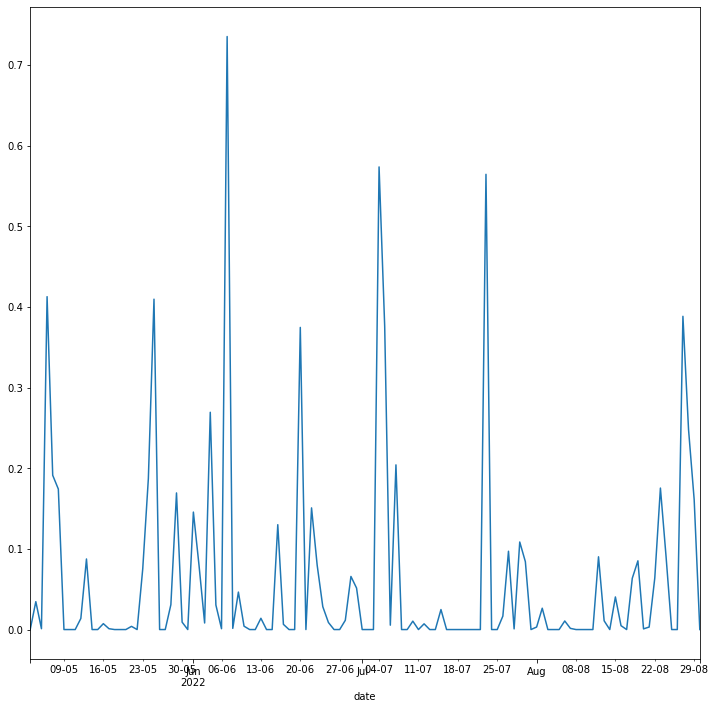

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#path_to_raw = r'C:\Users\Elisabeth.Verwuester\Documents\LIFE\00_Dachgarten_Berechnungen\python-spielereien'

df_ET = pd.read_csv("ET_messdaten_2022.csv", sep="\t", encoding='utf-8-sig')

df_ET['Wasserzaehler_L']=pd.to_numeric(df_ET['Wasserzaehler_L'])

df_ET['date']=pd.to_datetime(df_ET['date'], format='%d.%m.%Y')

df_ET.set_index('date', inplace=True)


fig, ax = plt.subplots(figsize=(12, 12))
df_ET['NS_L/h/m²'].plot(label='NS')
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m"))
df_ET.head()


Interpolation

<AxesSubplot:xlabel='date', ylabel='Wasserzaehler L'>

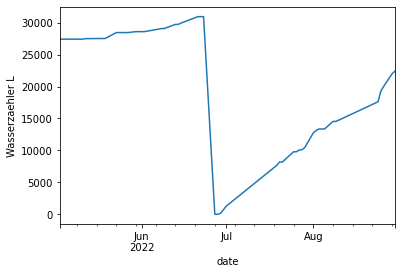

In [365]:
df_ET['Beet_1_cm']=df_ET['Beet_1_cm'].interpolate()
df_ET['Beet_8_cm']=df_ET['Beet_8_cm'].interpolate()
df_ET['Beet_16_cm']=df_ET['Beet_16_cm'].interpolate()

df_ET['Wasserzaehler_L']=df_ET['Wasserzaehler_L'].interpolate()
df_ET['RT1_cm']=df_ET['RT1_cm'].interpolate()
df_ET['RT2_cm']=df_ET['RT2_cm'].interpolate()

#df_ET.tail()
#df_ET['Beet_1_cm'].plot()
#df_ET.info()
df_ET['Wasserzaehler_L'].plot(ylabel='Wasserzaehler L') # Wasserzaehler wurde auf null gesetzt kurz vor Tag 60


PLOTTING

<AxesSubplot:xlabel='date', ylabel='Wasserzaehler L'>

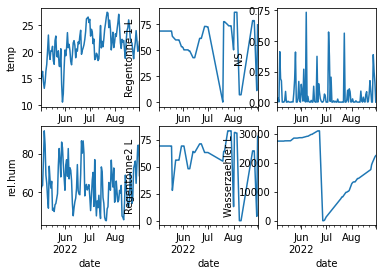

In [366]:
# PLOTTING
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from numpy import size
from matplotlib.pyplot import figure
     
#date_form=DateFormatter("%y-%m-%d")
fig, axes = plt.subplots(nrows=2, ncols=3)
#figure(figsize=(10,12))
df_ET['temp_°C'].plot(ax=axes[0,0], ylabel='temp')
df_ET['rel.hum_%'].plot(ax=axes[1,0], ylabel='rel.hum')
df_ET['NS_L/h/m²'].plot(ax=axes[0,2], ylabel='NS')
df_ET['RT1_cm'].plot(ax=axes[0,1], ylabel='Regentonne 1 L')
df_ET['RT2_cm'].plot(ax=axes[1,1], ylabel='Regentonne2 L')
df_ET['Wasserzaehler_L'].plot(ax=axes[1,2], ylabel='Wasserzaehler L')






APPROXIMATIONS: from water level in bed to total water volume

<AxesSubplot:xlabel='date', ylabel='water per bed'>

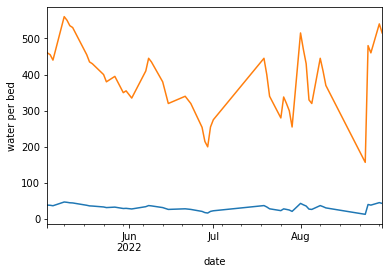

In [367]:
import math

# Regentonnen Volumen: 310L
# r 0.29 m unterer Radius
# R 0.375 m oberer Radius
# RT_1, RT_2 = cm Höhe
# von Pegel (RT_x) der Regentonnen auf Volumen in L: (RT_x/100 * pi/3) * (R^2 + rR + r^2)

r_unten=0.29 #m
R_oben=0.375 #m
conversion_fac=(1/100 * math.pi/3) * (pow(R_oben,2) + r_unten*R_oben + pow(r_unten,2))*1000 #  conversion from pegelhöhe to volume
df_ET['RT_L']=(df_ET['RT1_cm']*conversion_fac + df_ET['RT2_cm']*conversion_fac)
#df_ET['RT_L'].plot()


# Wasserreservoir Füllemge Beet 1+8+16
# Front Volumen Annäherung durch Trapez:
# L 105 cm (L_oben=112, L_unten=98, mittelwert=105) länge
# b1 = 23 cm, breite unten
# b2 30 cm, breite oben
# h = 70 cm , höhe/tiefe
# volumen = f(pegel): (L(b1+(b2-b1)*MW/h+b1)*h/2)/1000
L_reservoir_front = 105 # cm
breite_unten=23 #cm
breite_oben=30#cm
tiefe=70#cm

# Mittelung der drei Pegel, cm
df_ET['3Beet_avg_cm'] =df_ET[['Beet_1_cm', 'Beet_8_cm', 'Beet_16_cm']].mean(axis=1) # pegel avg in cm

# volumen = f(pegel): (L(b1+(b2-b1)*MW/h+b1)*h/2)/1000
df_ET['Vol_reservoir_front']=(L_reservoir_front*(breite_unten+(breite_oben-breite_unten)*df_ET['3Beet_avg_cm']/tiefe+breite_unten)*df_ET['3Beet_avg_cm']/2)/1000
df_ET['Vol_reservoir_front'].plot(ylabel='water reservoir front, L')

# Drainageschicht Füllmenge Beet1+8+16 in L
# bei 20cm Pegel: 550 L in Drainageschicht (RT-Bericht)
# -> 1cm : 27.5 L

df_ET['water_per_bed_L'] = (df_ET['3Beet_avg_cm']*27.5 + df_ET['Vol_reservoir_front']) # [L]

df_ET['water_per_bed_L'].plot(ylabel='water per bed')
#df_ET['NS_L/h/m²'].plot()





Daily Water Changes

<AxesSubplot:xlabel='date'>

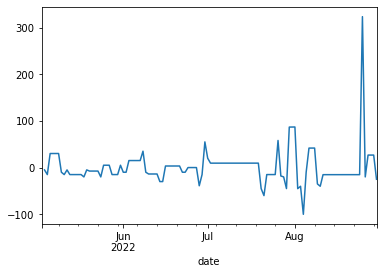

In [368]:
df_ET['delta_RT_L_per_day']=df_ET['RT_L'].diff()
df_ET['delta_water_per_bed_L_per_day']=df_ET['water_per_bed_L'].diff() # volumsänderung pro tag der beet-wasser-reservoirs
df_ET['delta_Wasserzaehler_L_per_day'] = df_ET['Wasserzaehler_L'].diff()

# replace neg values with 0
df_ET[df_ET['delta_Wasserzaehler_L_per_day']<0]=0

#df_ET['RT_L/day'].plot()
#df_ET['Wasserzaehler_L_per_day'].plot()
df_ET['delta_water_per_bed_L_per_day'].plot()
#df_ET['NS_L/h/m²'].plot()


Gardena-Giesswasser und Regentonnen Bilanz

<AxesSubplot:xlabel='date'>

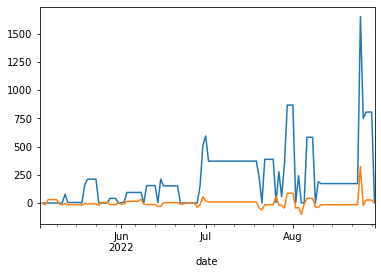

In [369]:
# Die Menge Wasser die mittels Wasserzähler aufgezeichnet wird, wird auch zur Befüllung der Regentonnen [RT_1 und RT_"] verwendet.
# Daher wird diese Wassermenge mit der Pegelstandsänderung der Regentonnen bilanziert um die Menge an reinem Giesswasser zu ermitteln.

df_ET['Watering_L_per_day']=df_ET['delta_Wasserzaehler_L_per_day']-df_ET['delta_RT_L_per_day']
df_ET[df_ET['Watering_L_per_day']<0]=0
df_ET['Watering_L_per_day'].plot()
df_ET['delta_water_per_bed_L_per_day'].plot()


WASSERBILANZ

In [375]:


# Beetfläche total: 110 m²
total_bed_area = 110.0 #m²
number_of_beds = 19.0

# df_ET.rename(columns={'NS_L/h/m²':'NS_L_per_sq_m'}, inplace=True)
# regenmenge pro tag für den gesamten dachgarten
df_ET['NS_L_per_day']=df_ET['NS_L/h/m²']*24*total_bed_area 
df_ET['delta_water_L_per_day']=df_ET['delta_water_per_bed_L_per_day']*number_of_beds
df_ET['evapo_L_per_day']= df_ET['NS_L_per_day']+df_ET['Watering_L_per_day']-df_ET['delta_water_L_per_day'] 
# replace neg values with 0
df_ET[df_ET['evapo_L_per_day']<0]=0 # Evapotranspiration [L/day]
df_ET['evapo_L_per_day_per_m2']=df_ET['evapo_L_per_day']/total_bed_area




FILTERING POTENTIAL DAYS FOR COOLING CALCULATION

In [371]:
# filtering out rainy days
df_ET=df_ET[df_ET.NS_L_per_day<5.0]
# identifying max evapotranspiration
df_ET.evapo_L_per_day.max()
# identifying according day

cooling_date=df_ET.index[df_ET.evapo_L_per_day==df_ET.evapo_L_per_day.max()]
cooling_date
#cooling_date = df_ET.date[df_ET.evapo_L_per_day==df_ET.evapo_L_per_day.max()]

# identifying index to get temp, rel.hum and exporting float via to.numpy
#cooling_index = df_ET[df_ET.evapo_L_per_day==df_ET.evapo_L_per_day.max()].index.values
#int(cooling_index)
cooling_calc_temp = df_ET['temp_°C'].loc[cooling_date].to_numpy()[0] #°C
cooling_calc_hum = df_ET['rel.hum_%'].loc[cooling_date].to_numpy()[0] # %
cooling_calc_ET = df_ET['evapo_L_per_day'].loc[cooling_date].to_numpy()[0] # kg/day
#cooling_calc_ET = df_ET.evapo_L_per_day.max() # kg/day

print('for calculating the potential cooling day:', cooling_date, 'with temp:', cooling_calc_temp, ' rel.hum:', cooling_calc_hum, 'and ET: ', cooling_calc_ET )


for calculating the potential cooling day: DatetimeIndex(['2022-08-04'], dtype='datetime64[ns]', name='date', freq=None) with temp: 25.4775  rel.hum: 55.1136 and ET:  1904.7860710169268


RADIATION BASED EVAPOTRANSPIRATION

In [372]:
import numpy as np

# import of radiation for specified day (previous step)

df_SOEIN = pd.read_csv("04082022_SOEIN.csv", sep="\t", encoding='utf-8-sig')
df_SOEIN.timestamp=pd.to_datetime(df_SOEIN.timestamp)

# set radiation boundaries to get hours of daylight
df_SOEIN=df_SOEIN[df_SOEIN['SOEIN_W/m2']>0.6]
df_SOEIN['soein_norm']=(df_SOEIN['SOEIN_W/m2']/ df_SOEIN['SOEIN_W/m2'].max())
radiation_array= df_SOEIN['soein_norm'].to_numpy() # len 32

# array for time scale of 15.5 h with 30min spacing
radiation_time_array=np.arange(0,16,0.5,dtype=float) # len 32
radiation_integral=np.trapz(radiation_array, radiation_time_array)

cooling_calc_ET_per_m2 = cooling_calc_ET/total_bed_area # evapotranspiration kg/m²day

# ---------------------------------------
# BISECTION METHOD

def error_fct_rad_ET(radiation_based_ET):
    radiation_ET_array=radiation_array*radiation_based_ET
    radiation_ET_integral=np.trapz(radiation_ET_array, radiation_time_array)
    diff_ET_area = cooling_calc_ET_per_m2 - radiation_ET_integral
    return diff_ET_area

#low and high limit for bisection method
ET_low = -25.0 #
ET_high = 30.0
convergence=1.0E-8
max_iteration = 200
iteration = 0

while iteration <= max_iteration:
    ET_3 = (ET_low + ET_high)/2
    error_ET_low = error_fct_rad_ET(ET_low)
    error_ET_3 = error_fct_rad_ET(ET_3)
    #print(error_temp1, error_temp3, temp1, temp2,temp3)
    if (error_ET_3 * error_ET_low) < 0:
        ET_high=ET_3
    else:
         ET_low=ET_3   
    REC = abs(error_ET_3/ET_3)
    if REC < convergence:
        print("TWB", ET_3, "at iteration", iteration, "was found, with convergence of", REC)
        break
    else:
         iteration+=1
print("method ended")

radiation_based_ET = ET_3

# ---------------------------------------


print('radiation_based_ET: ', radiation_based_ET,'kg/m²30min')

#df_SOEIN['soein_norm'].plot()


TWB 2.039555500668939 at iteration 33 was found, with convergence of 4.4150171741821115e-10
method ended
radiation_based_ET:  2.039555500668939 kg/m²30min


BISECTION METHODE for potential Cooling Effect

In [373]:
import math
import csv
from tkinter import N
#####################################################################################
#
#   using bisection method to iteratively approximate first the wet bulb temp       #
#   and subsequently the dry bulb temp.                                             #
#   inputs from measurements are: T-AIR[°C], REL-HUM[%], ETR[g/m³ in KV per second]
#
#####################################################################################


# CONSTANTS
gas_const = 461.52 #J/kgK spedific gas constant for water
Rooftop_Volume = 3970.94 #m³
# HARDCODED
rel_hum = cooling_calc_hum #55.1136 #%
t_air = cooling_calc_temp #25.4775 # °C
ET = radiation_based_ET/Rooftop_Volume*1000/30/60 # Conversion kg/m²30min to g/m²s per Rooftop-Volume
ET *= total_bed_area # ET for total bed area in g/m³s

#buck saturation vapor pressure at temp [bar]
def buck(temp):
    saturation_vapor_pressure = (0.61121*math.exp((18.678-temp/234.5)*(temp/(257.14+temp))))/100
    return saturation_vapor_pressure


#########################################################
#                                                       #
#       APPROXIMATION OF WET BULB TEMPERATURE           #
#                                                       #
#########################################################

p_vs=buck(t_air)

def error_fct_wb(temp):
    p_vs_wb=buck(temp)#p_vs at twb
    p_v = p_vs_wb-(1.8*(t_air-temp))/2700#apjohn equation for vapor pressure f(twb,tdb) [bar]
    error = (rel_hum * p_vs)/100 - p_v #error fct comparing two approches to solve p_v; apjohn versus p_vs*rel.hum
    return error

# BISECTION METHOD
#low (temp1) and high (temp2) limit for bisection method to calc twb
temp1=-25.0
temp2=30.0
convergence=1.0E-8
max_iteration = 200
iteration = 0

twb_df =[] # empty list to be filled with TWB iterations during the bisection method

while iteration <= max_iteration:
    temp3 = (temp1+temp2)/2
    error_temp1 = error_fct_wb(temp1)
    error_temp3 = error_fct_wb(temp3)
    twb_df.append(temp3)
    #print(error_temp1, error_temp3, temp1, temp2,temp3)
    if (error_temp3 * error_temp1) < 0:
        temp2=temp3
    else:
         temp1=temp3   
    REC = abs(error_temp3/temp3)
    if REC < convergence:
        print("TWB", temp3, "at iteration", iteration, "was found, with convergence of", REC)
        break
    else:
         iteration+=1
print("method ended")

twb = temp3
p_vs_wb=buck(twb) 


#########################################################
#                                                       #
#       APPROXIMATION OF DRY BULB TEMPERATURE           #
#                                                       #
#########################################################


def error_fct_tdb(temp):
    p_vs_db=buck(temp)
    max_hum_ET =(p_vs_db*100000/(gas_const*(temp+273.15)))*1000 # ideal gas law to calc maximum humidity [g/m³]
    max_hum = (p_vs*100000/(gas_const*(t_air+273.15)))*1000
    abs_hum = max_hum * rel_hum /100 #calc for absolute humidity [g/m³]
    abs_hum_ET = abs_hum + ETR # add water from ET
    rel_hum_ET = abs_hum_ET/max_hum_ET #calc for relative humidity inkl ET, NOT in %
    p_v = p_vs_wb-(1.8*(temp-twb))/2700 #apjohn equation for vapor pressure f(twb,tdb) [bar]
    error = (rel_hum_ET * p_vs_db) - p_v #error fct comparing two approches to solve p_v; apjohn versus p_vs*rel.hum
    return error


 # BISECTION METHOD to calc potential cooling

tdb_df =[] # empty list to be filled with TDB iterations during the bisection method

with open('results_sec.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ETR,g/m³s', 'sec', 'tdb,°C', 'temp_depression,°C', 'twb,°C'])
    duration = list(range(200)) #Duration of Evaporation in seconds
    
    for i in duration:
        temp1=-20.0 # low limit twb
        temp2=30.0  # high limit twb
        SEC=duration[i]
        ETR=ET*SEC
        iteration=0
        convergence=1.0E-9
        max_iteration = 100
        print('\n','START: duration', duration[i],'ETR', ETR, 'sec', SEC)
        
        while iteration <= max_iteration:
            temp3 = (temp1+temp2)/2
            error_temp1 = error_fct_tdb(temp1)
            error_temp3 = error_fct_tdb(temp3)
            tdb_df.append(temp3)
            #print(error_temp1, error_temp3, temp1, temp2,temp3)
	    #print('iteration',iteration,'ETR', ETR, 'SEC', SEC)
            if (error_temp3 * error_temp1) < 0:
                temp2=temp3
            else:
                temp1=temp3
                REC = abs(error_temp3/temp3)
		#print(REC)
            if REC < convergence:
                print("TDB", temp3, "at iteration", iteration, "was found, with convergence of", REC)
                iteration=max_iteration
            else:
                iteration+=1
            iteration+=1
	#print("method ended")
			
        tdb=temp3
        temp_depression = t_air - tdb
        

        print("temp depression is", round(temp_depression,2))
        
    

#########################################################
#                                                       #
#                   PLAUSIBILITY CHECKS                 #
#                                                       #
#########################################################

        if tdb<twb:
            print("TDB < TWB, not plausible, decrease duration [sec]")
		
        p_vs_db=buck(tdb)
        max_hum_ET =(p_vs_db*100000/(gas_const*(tdb+273.15)))*1000 # ideal gas law to calc maximum humidity [g/m³]
        max_hum = (p_vs*100000/(gas_const*(t_air+273.15)))*1000
        abs_hum = max_hum * rel_hum /100
        abs_hum_ET = abs_hum + ETR

        if abs_hum_ET > max_hum_ET:
            print("absolute humidity exceeds maximum humidity, not plausible, decrease duration [sec]")
        else:
            print("temp depression is", round(temp_depression,2))
            
        writer.writerow([ETR, SEC, tdb, temp_depression, twb])

#twb_df = pd.DataFrame(twb_df)
#twb_df.plot(ylabel='approximation of TWB, °C')
#tdb_df=pd.DataFrame(tdb_df)
#tdb_df.plot()



TWB 19.152069091796875 at iteration 14 was found, with convergence of 4.520070184958867e-10
method ended

 START: duration 0 ETR 0.0 sec 0
TDB 25.47748565673828 at iteration 34 was found, with convergence of 7.489739328116738e-10
temp depression is 0.0
temp depression is 0.0

 START: duration 1 ETR 0.03138790886255078 sec 1
TDB 25.41797637939453 at iteration 34 was found, with convergence of 8.329050434578407e-10
temp depression is 0.06
temp depression is 0.06

 START: duration 2 ETR 0.06277581772510156 sec 2
TDB 25.3585147857666 at iteration 38 was found, with convergence of 2.29864220285594e-10
temp depression is 0.12
temp depression is 0.12

 START: duration 3 ETR 0.09416372658765235 sec 3
TDB 25.299053192138672 at iteration 36 was found, with convergence of 3.049386168171603e-10
temp depression is 0.18
temp depression is 0.18

 START: duration 4 ETR 0.12555163545020312 sec 4
TDB 25.239615440368652 at iteration 40 was found, with convergence of 3.7579470204421755e-10
temp depression

plots